# PROJET 9 : PRÉDISEZ LA DEMANDE EN ÉLECTRICITÉ

## PRÉALABLES :

### A - Importation des librairies et fonctions:

In [1]:
# Importation des librairies :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(14,6))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return

### B - Importation des fichiers :

In [3]:
# Importation des fichiers :
data = pd.read_excel("Elect.xls")
DJU = pd.read_excel("calcul_DJU.xlsx")

### C - Conversion des colonnes :

#### 1 - Conversion de la colonne temporelle :

In [4]:
data["Mois"] = pd.to_datetime(data["Mois"])

#### 2 - Titres des colonnes à plusieurs mots :

In [5]:
# Changement de nom
data.rename(columns={"Production totale":"Production_totale"}, inplace=True)
data.rename(columns={"Production nucléaire":"Production_nucléaire"}, inplace=True)
data.rename(columns={"Production thermique totale":"Production_thermique_totale"}, inplace=True)
data.rename(columns={"Production thermique charbon":"Production_thermique_charbon"}, inplace=True)
data.rename(columns={"Production thermique fioul":"Production_thermique_fioul"}, inplace=True)
data.rename(columns={"Production thermique gaz":"Production_thermique_gaz"}, inplace=True)
data.rename(columns={"Production hydraulique":"Production_hydraulique"}, inplace=True)
data.rename(columns={"Production éolien":"Production_éolien"}, inplace=True)
data.rename(columns={"Production solaire":"Production_solaire"}, inplace=True)
data.rename(columns={"Production bioénergies":"Production_bioénergies"}, inplace=True)
data.rename(columns={"Consommation totale":"Consommation_totale"}, inplace=True)
data.rename(columns={"Solde exportateur":"Solde_exportateur"}, inplace=True)
data.rename(columns={"Echanges export":"Echanges_export"}, inplace=True)
data.rename(columns={"Echanges import":"Echanges_import"}, inplace=True)
data.rename(columns={"Echanges avec le Royaume-Uni":"Echanges_UK"}, inplace=True)
data.rename(columns={"Echanges avec l'Espagne":"Echanges_Espagne"}, inplace=True)
data.rename(columns={"Echanges avec l'Italie":"Echanges_Italie"}, inplace=True)
data.rename(columns={"Echanges avec la Suisse":"Echanges_Suisse"}, inplace=True)
data.rename(columns={"Echanges avec l'Allemagne et la Belgique":"Echanges_AllemagneEtBelgique"}, inplace=True)

### D - Suppression des données consolidées :

In [6]:
# Suppression des données consolidées :
data = data[data["Qualité"]=="Données définitives"]

### E - DJU

#### 1 - Adaptation du tableau DJU :

In [7]:
# Suppression des premières entrées :
DJU = DJU.drop(index=[0,1,2,3,4,5,6,7,8,9,10])
DJU = DJU.drop(columns=["Unnamed: 13"])

In [8]:
# Renommage des colonnes :
DJU = DJU.rename(columns={"Export DJU 21/03/2021":"Année", "Unnamed: 1": "Janvier", "Unnamed: 2": "Février", "Unnamed: 3": "Mars", "Unnamed: 4": "Avril", "Unnamed: 5": "Mai", "Unnamed: 6": "Juin", "Unnamed: 7": "Juillet", "Unnamed: 8": "Août", "Unnamed: 9": "Septembre", "Unnamed: 10": "Octobre", "Unnamed: 11": "Novembre", "Unnamed: 12": "Décembre"})
DJU = DJU.set_index("Année")

In [9]:
# Transformation du tableau :
dataDJU = pd.concat([DJU.iloc[7], DJU.iloc[6], DJU.iloc[5], DJU.iloc[4], DJU.iloc[3], DJU.iloc[2], DJU.iloc[1], DJU.iloc[0]])
dataDJU = pd.DataFrame(dataDJU)
dataDJU = dataDJU.rename(columns={0:"DJU"})
dataDJU = dataDJU.reset_index(drop=True)
dataDJU = dataDJU[["DJU"]]

### F - Tableau Final :

In [10]:
# Restriction sur les valeurs nationales :
dataFra = data[data.Territoire=="France"]
dataFra = dataFra.reset_index(drop=True)

In [11]:
# Jonction des données DJU
dataFra = dataFra.join(dataDJU["DJU"])

In [12]:
# Transformation de la colonne "DJU" :
dataFra["DJU"] = dataFra["DJU"].astype("float64")

In [13]:
# Correction de la valeur DJU de décembre 2019 (Moyenne des autres mois de décembre)
MeanDJUDecember = dataFra.loc[(dataFra["Mois"].dt.month==12)]
MeanDJUDecember.drop([95])
MeanDJUDecember = MeanDJUDecember["DJU"].mean()
dataFra["DJU"] = dataFra["DJU"].replace(dataFra["DJU"][95], MeanDJUDecember)

## 0 - Représenter la série temporelle :

### A - Graphiques production :

#### 1 - Production totale :

Text(0.5, 1.0, "Production totale d'électricité en France")

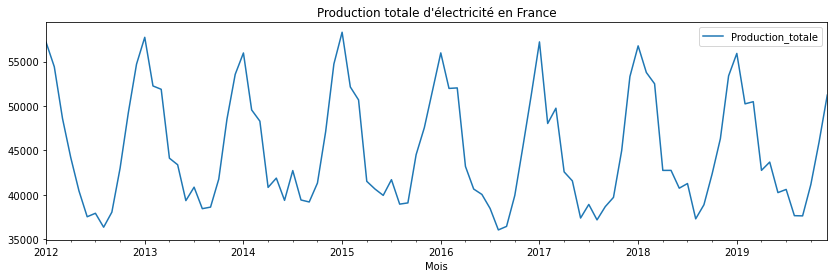

In [14]:
# Production Totale :
dataFra.plot(x="Mois", y="Production_totale", figsize=(14,4))
plt.title("Production totale d'électricité en France")

#### 2 - Production énergie solaire :

Text(0.5, 1.0, "Production d'énergie solaire en France")

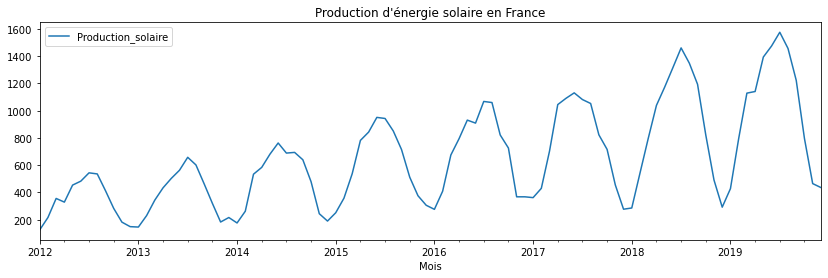

In [15]:
# Production énergie solaire :
dataFra.plot(x="Mois", y="Production_solaire", figsize=(14,4))
plt.title("Production d'énergie solaire en France")

#### 3 - Production énergie hydraulique :

Text(0.5, 1.0, "Production d'énergie hydraulique en France")

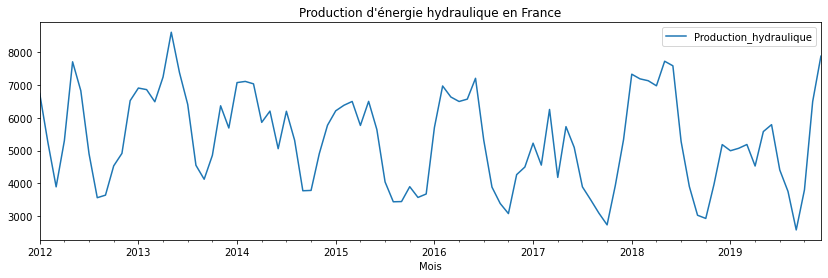

In [16]:
# Production énergie hydraulique :
dataFra.plot(x="Mois", y="Production_hydraulique", figsize=(14,4))
plt.title("Production d'énergie hydraulique en France")

#### 4 - Production énergie nucléaire :

Text(0.5, 1.0, "Production d'énergie nucléaire en France")

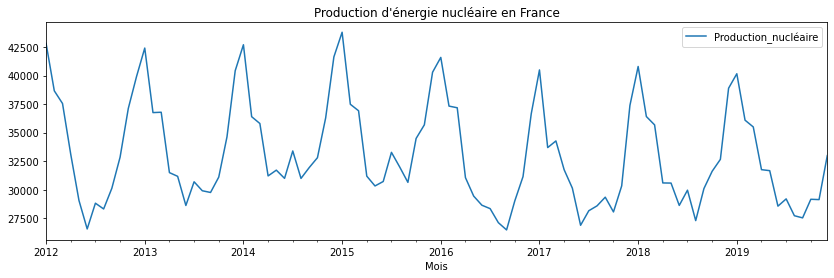

In [17]:
# Production énergie nucléaire :
dataFra.plot(x="Mois", y="Production_nucléaire", figsize=(14,4))
plt.title("Production d'énergie nucléaire en France")

#### 5 - Comparaison des production des deux régions :

Text(0.5, 1.0, "Production totale d'électricité dans Grand-Est")

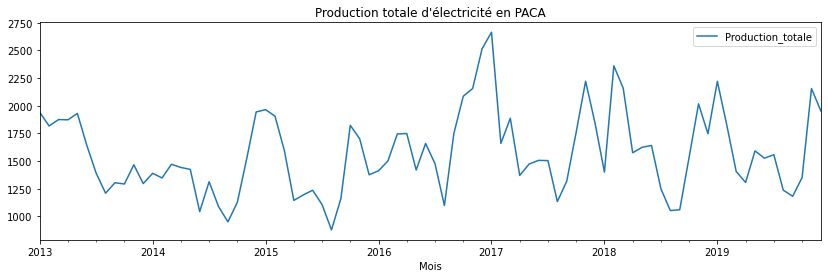

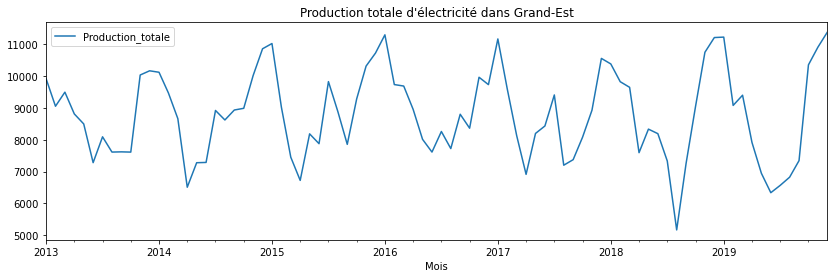

In [18]:
# Comparaison des deux régions :
dataPACA = data[data.Territoire=="PACA"]
dataPACA.plot(x="Mois", y="Production_totale", figsize=(14,4))
plt.title("Production totale d'électricité en PACA")
dataGrandEst = data[data.Territoire=="Grand-Est"]
dataGrandEst.plot(x="Mois", y="Production_totale", figsize=(14,4))
plt.title("Production totale d'électricité dans Grand-Est")

## I - Corriger la consommation en utilisant une régression linéaire :

### A - Comparaison visuelle :

Text(0.5, 1.0, 'Degrés Jour Unifiés')

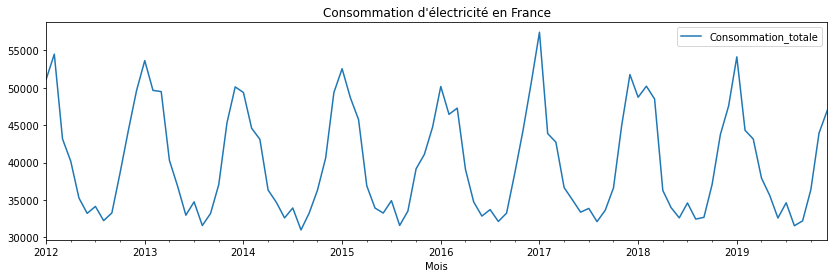

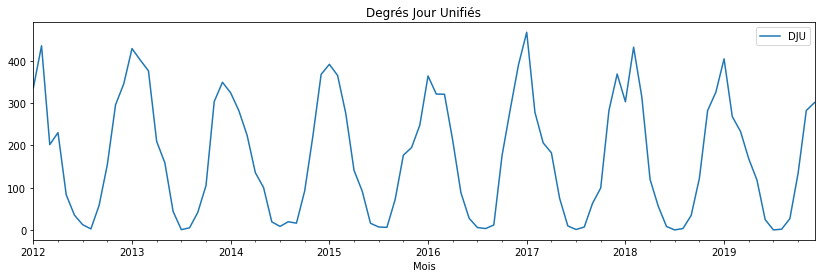

In [19]:
# Visualisation
dataFra.plot(x="Mois", y="Consommation_totale", figsize=(14,4))
plt.title("Consommation d'électricité en France")
dataFra.plot(x="Mois", y="DJU", figsize=(14,4))
plt.title("Degrés Jour Unifiés")

### B - Régression linéaire :

#### 1 - Calculs :

In [20]:
# Regression linéaire Consommation_totale expliquée par DJU :
reg = smf.ols("Consommation_totale ~ DJU", data=dataFra).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Consommation_totale   R-squared:                       0.953
Model:                             OLS   Adj. R-squared:                  0.953
Method:                  Least Squares   F-statistic:                     1910.
Date:                 Mon, 07 Jun 2021   Prob (F-statistic):           2.99e-64
Time:                         16:32:41   Log-Likelihood:                -840.00
No. Observations:                   96   AIC:                             1684.
Df Residuals:                       94   BIC:                             1689.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.159e+04    249.141    126.800      0.000    3.11e+04    3.21e+04
DJU           48.7012      1.114     43.700      0.000      46.488      50.914
==============================================================================
Omnibus:                        1.616   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.551
Skew:                           0.212   Prob(JB):                        0.460
Kurtosis:                       2.543   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2 - Récupération du coefficient de la régression :

In [21]:
# Récupération du coefficient DJU :
coefDJU = reg.params["DJU"]

#### 3 - Correction de la consommation :

In [22]:
# Correction de la consommation en lui retirant la valeur DJU mise à l'échelle de la régression :
dataFra["Consommation_corrigée"] = dataFra["Consommation_totale"] - dataFra["DJU"] * reg.params["DJU"]

### C - Visualisation du résultat :

Text(0.5, 1.0, "Consommation d'énergie en France et consommation corrigée de l'effet température")

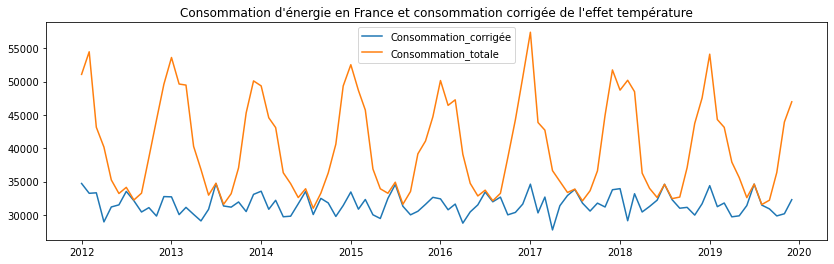

In [23]:
# Visualisation de la consommation totale et de la correction en regression :
plt.figure(figsize=(14,4))
plt.plot(dataFra.Mois, dataFra["Consommation_corrigée"], label="Consommation_corrigée")
plt.plot(dataFra.Mois, dataFra["Consommation_totale"], label="Consommation_totale")
plt.legend()
plt.title("Consommation d'énergie en France et consommation corrigée de l'effet température")

## II - DÉSAISONNALISER LA CONSOMMATION AVEC DES MOYENNES MOBILES :

### A - Décomposition :

#### 1 - Définitions :

In [24]:
# Définition de X :
x = dataFra[["Mois","Consommation_corrigée"]]
x = x.set_index("Mois")

#### 2 - Seasonal_decompose :

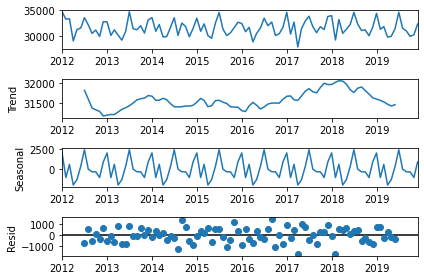

In [25]:
# Calculs et visualisation :
decomp_x = seasonal_decompose(x,  model='additive')
decomp_x.plot()
plt.show()

### B - Visualisation de la décomposition :

Text(0, 0.5, 'Residual')

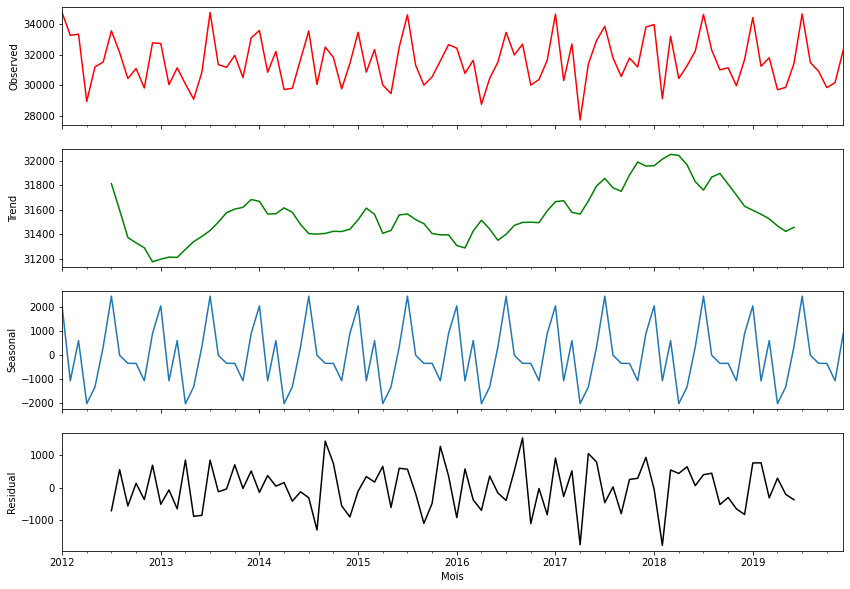

In [26]:
# Visualisation de la décomposition :
fig, axes = plt.subplots(4, 1, sharex=True)

decomp_x.observed.plot(ax=axes[0], legend=False, color='r', figsize=(14,10))
axes[0].set_ylabel('Observed')
decomp_x.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomp_x.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomp_x.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

### C - Correction des effets saisonniers :

In [27]:
# Correction de la consommation en lui retirant les effets saisonniers calculés lors de la décomposition :
dataFra["Consommation_corrigée_désaisonnalisée"]=dataFra["Consommation_corrigée"] - decomp_x.seasonal.values

### D - Comparaison des courbes :

#### 1 - Consommation corrigée et consommation désaisonnalisée :

Text(0.5, 1.0, 'Consommation corrigée et consommation corrigée et désaisonnalisée')

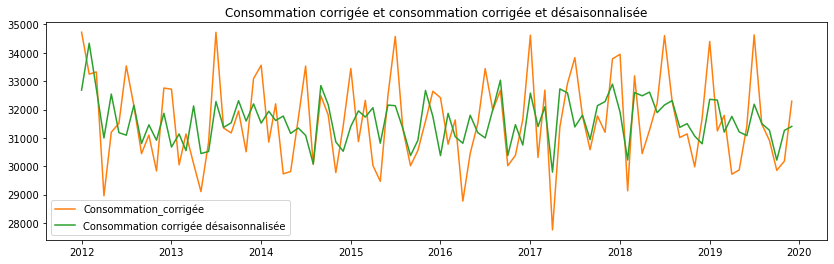

In [28]:
# Visualisation de la consommation corrigée et de la consommation corrigée et désaisonnalisée :
plt.figure(figsize=(14,4))
plt.plot(dataFra.Mois, dataFra["Consommation_corrigée"], label="Consommation_corrigée", color="tab:orange")
plt.plot(dataFra.Mois, dataFra["Consommation_corrigée_désaisonnalisée"], label="Consommation corrigée désaisonnalisée", color="tab:green")
plt.legend()
plt.title("Consommation corrigée et consommation corrigée et désaisonnalisée")

#### 2 - Consommation totale, consommation corrigée et consommation désaisonnalisée :

Text(0.5, 1.0, "Consommation d'énergie en France (brute, corrigée et corrigée et désaisonnalisée)")

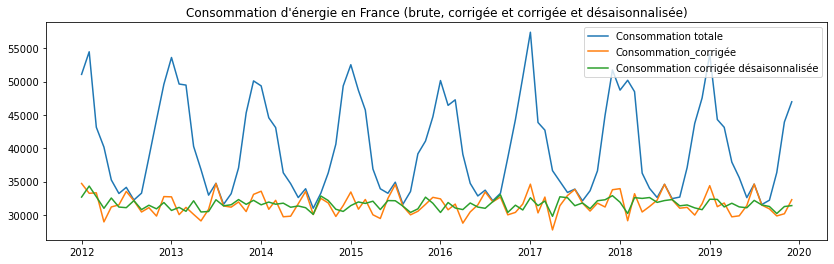

In [29]:
# Visualisation de la consommation consommation corrigée et de la consommation corrigée et désaisonnalisée :
plt.figure(figsize=(14,4))
plt.plot(dataFra.Mois, dataFra["Consommation_totale"], label="Consommation totale")
plt.plot(dataFra.Mois, dataFra["Consommation_corrigée"], label="Consommation_corrigée")
plt.plot(dataFra.Mois, dataFra["Consommation_corrigée_désaisonnalisée"], label="Consommation corrigée désaisonnalisée")
plt.legend()
plt.title("Consommation d'énergie en France (brute, corrigée et corrigée et désaisonnalisée)")

## III - Modèle de prédiction de la consommation d'électricité :

### A - Méthodes de lissage exponentiel (Holt-Winters) :

#### 1 - Définitions :

In [30]:
# Définition :
x = dataFra[["Mois","Consommation_corrigée"]]
x = x.set_index("Mois")
y = np.log(x)

#### 2 - Modèlisation :

In [31]:
# Modélisation Holt-Winters :
hw = ExponentialSmoothing(np.asarray(y["Consommation_corrigée"]), seasonal_periods=12, trend="add", seasonal="add").fit()
print(hw.summary())    
shapiro(hw.resid)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   96
Model:             ExponentialSmoothing   SSE                              0.058
Optimized:                         True   AIC                           -679.162
Trend:                         Additive   BIC                           -638.132
Seasonal:                      Additive   AICC                          -670.278
Seasonal Periods:                    12   Date:                 Mon, 07 Jun 2021
Box-Cox:                          False   Time:                         16:32:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

ShapiroResult(statistic=0.9923039078712463, pvalue=0.8597081303596497)

#### 3 - Visualisation des prédictions par méthode Holt-Winters :

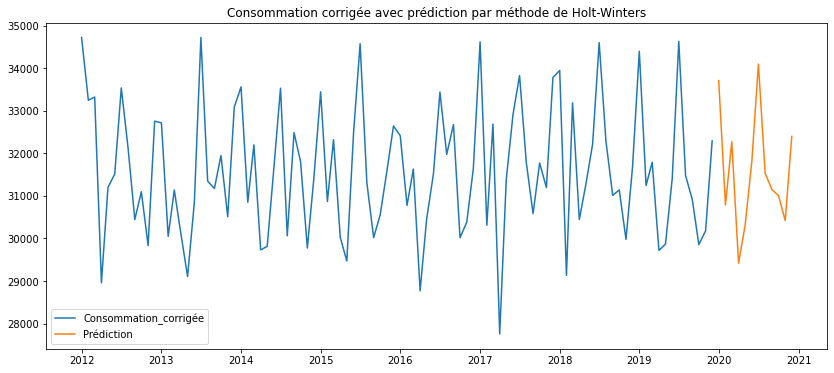

In [32]:
# Visualisation des prédications :
hw_pred = np.exp(hw.forecast(12))
plt.figure(figsize=(14,6))
plt.plot(np.exp(y["Consommation_corrigée"]), label="Consommation_corrigée")
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label="Prédiction")
plt.legend()
plt.title("Consommation corrigée avec prédiction par méthode de Holt-Winters")
plt.show()

#### 4 - Analyse a posteriori du modèle de Holt-Winters :

In [33]:
# Découpage
x_troncHW = x[:"2018"]
y_troncHW = np.log(x_troncHW)
x_a_prevoirHW = x["2019":]

In [34]:
# Modélisation du modèle tronqué :
hw2 = ExponentialSmoothing(np.asarray(y_troncHW["Consommation_corrigée"]), seasonal_periods=12, trend="add", seasonal="add").fit()
print(hw2.summary())    
shapiro(hw2.resid)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   84
Model:             ExponentialSmoothing   SSE                              0.055
Optimized:                         True   AIC                           -584.505
Trend:                         Additive   BIC                           -545.612
Seasonal:                      Additive   AICC                          -573.982
Seasonal Periods:                    12   Date:                 Mon, 07 Jun 2021
Box-Cox:                          False   Time:                         16:32:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

ShapiroResult(statistic=0.9884782433509827, pvalue=0.665452778339386)

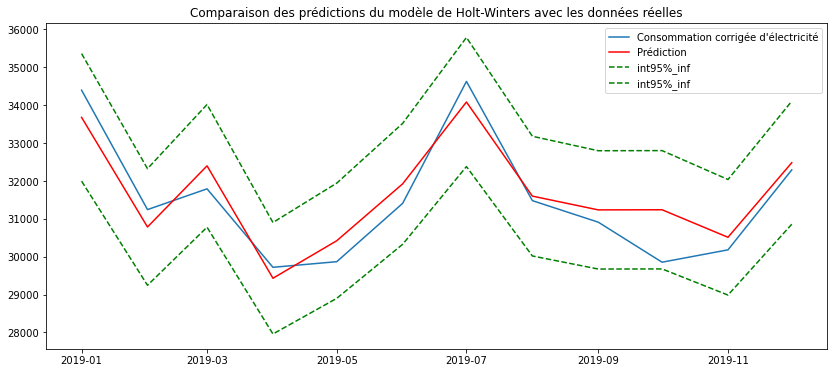

In [35]:
# Prédiction et comparaison :
pred_troncHW = np.exp(hw2.forecast(12))
pred_l_troncHW = pred_troncHW * 0.95
pred_u_troncHW = pred_troncHW * 1.05


plt.figure(figsize=(14,6))
plt.plot(x_a_prevoirHW, label="Consommation corrigée d'électricité")
plt.plot(x_a_prevoirHW.index, pred_troncHW, color='r', label="Prédiction")
plt.plot(x_a_prevoirHW.index, pred_l_troncHW, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoirHW.index, pred_u_troncHW, color='g', linestyle='--', label='int95%_inf')
plt.title("Comparaison des prédictions du modèle de Holt-Winters avec les données réelles")
plt.legend()
plt.show()

In [36]:
# RMSE :
rmseHW = np.sqrt(((x_a_prevoirHW["Consommation_corrigée"]-pred_troncHW)**2).mean())
rmseHW

593.5755949864324

In [37]:
# MAPE :
mapeHW = (np.abs(1-pred_troncHW/x_a_prevoirHW["Consommation_corrigée"])).mean()*100
mapeHW

1.6043411660486773

### B - Méthode SARIMA :

#### 1 - Paramètre de différenciation (d) :

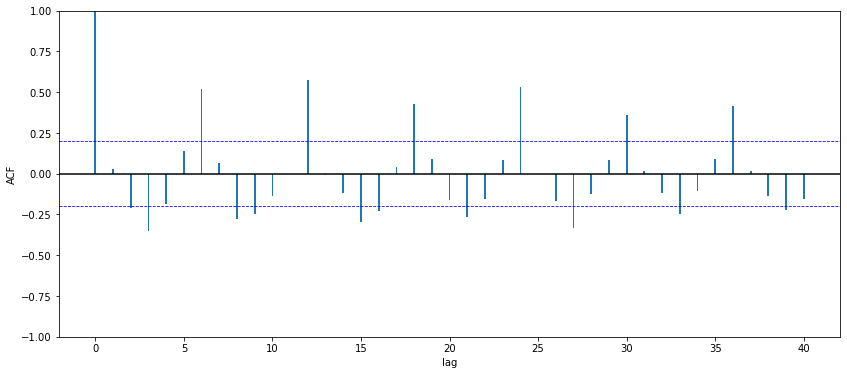

In [38]:
# Détermination du paramètre d :
y_len = len(y['Consommation_corrigée']) # variable nécessaire pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y['Consommation_corrigée'])), y_len)

In [39]:
# Test de Dickey-Fuller :
result = adfuller(y["Consommation_corrigée"])
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))

Statistiques ADF : -2.524520279759506
p-value : 0.10962168609913364


Avec une p-value de 0.11, il n'est pas possible de conclure que la série est stationnaire.

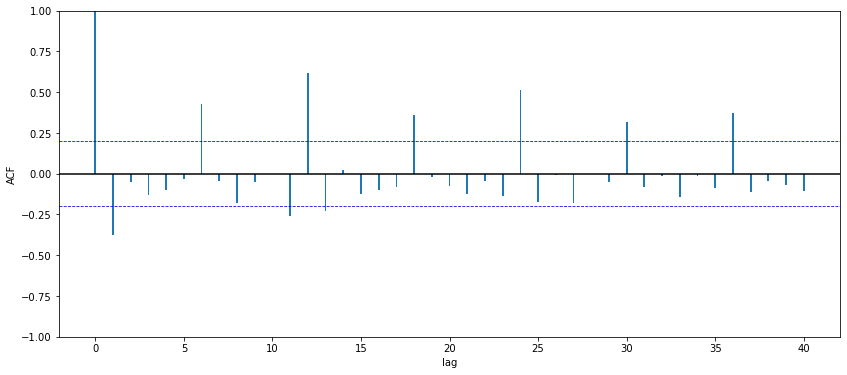

In [40]:
# Différenciation :
y_dif1 = y["Consommation_corrigée"] - y["Consommation_corrigée"].shift(1)

plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len)

In [41]:
# Test de Dickey-Fuller:
result = adfuller(y_dif1.dropna())
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))

Statistiques ADF : -5.5951451564889885
p-value : 1.3021629573264753e-06


La série temporelle devient statique après une différenciation.

d = 1

#### 2 - paramètre de saisonnalité (m) :

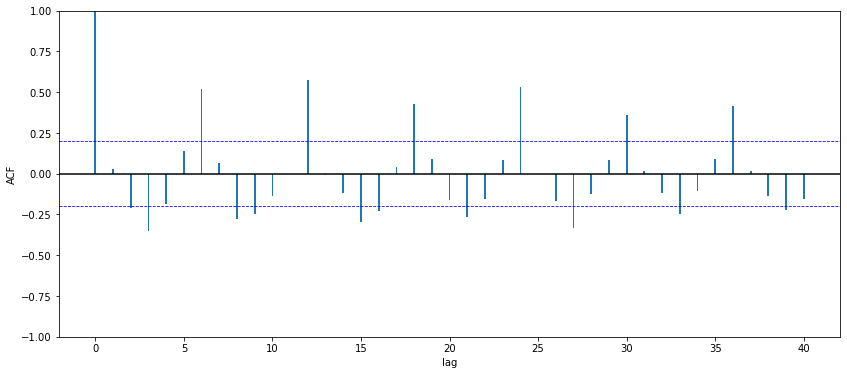

In [42]:
# acf
plot_sortie_acf(acf(np.asarray(y['Consommation_corrigée'])), y_len)

Les termes dépassent les valeurs significatives pour les multiples de 6, mais l'on sait que la série présente une saisonnalité sur une base annuelle, donc :

m = 12

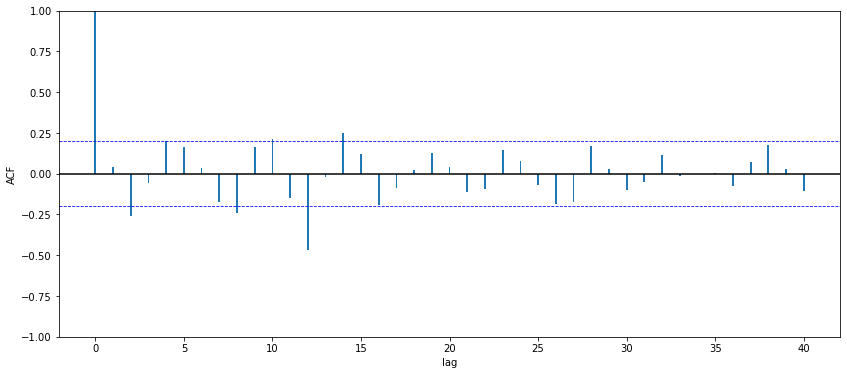

In [43]:
# Désaisonnalisation :
y_12 = y['Consommation_corrigée'] - y['Consommation_corrigée'].shift(12)
plot_sortie_acf(acf(np.asarray(y_12[13:])), y_len)

#### 3 - paramètre de différenciation saisonnière (D) :

In [44]:
# Stationnarité :
result = adfuller(y_12.dropna())
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))

Statistiques ADF : -3.1602051520883627
p-value : 0.022406841119317934


La série désaisonnalisée est déjà stationnaire :

D = 0

#### 3 - Sélection automatique des paramètres d'autorégression et de moyennes mobiles avec auto_arima :

In [45]:
# Sélection auto-arima
arima_model_tronc =  auto_arima(np.asarray(y["Consommation_corrigée"]), 
start_p=0, max_p=5,
start_q=0, max_q=5,
d=1, m=12,
start_P=0, max_P=5,
start_Q=0, max_Q=5,
D=0,
seasonal=True,
error_action='warn',
trace=True,
supress_warnings=True,
stepwise=True,
random_state=20,
n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-240.619, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.347, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-242.607, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-252.952, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-276.841, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-331.139, Time=0.52 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=-326.046, Time=1.16 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-328.899, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-327.903, Time=0.48 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=-325.899, Time=1.29 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : 

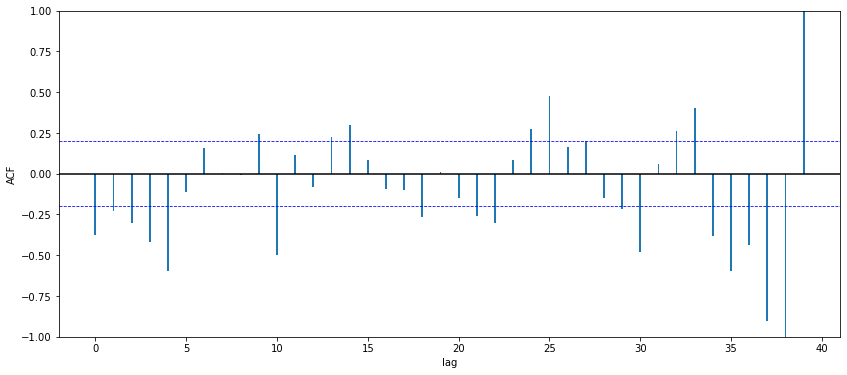

In [46]:
# Vérification du paramètre p = 5
plot_sortie_acf(pacf(np.asarray(y_dif1[1:])), y_len, pacf=True)

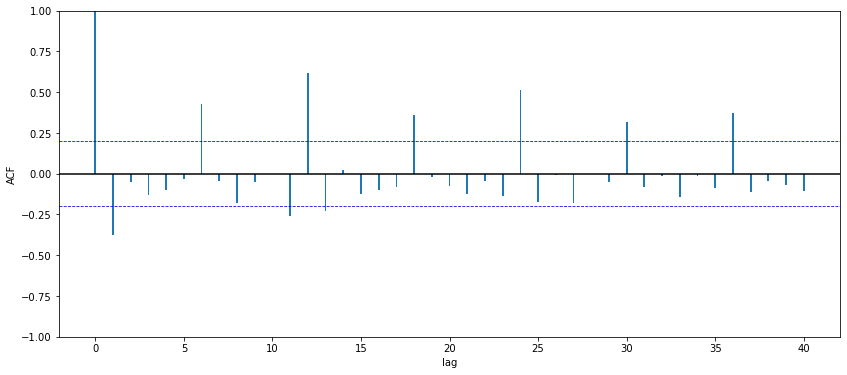

In [47]:
# Vérification du paramètre q = 0
plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len)

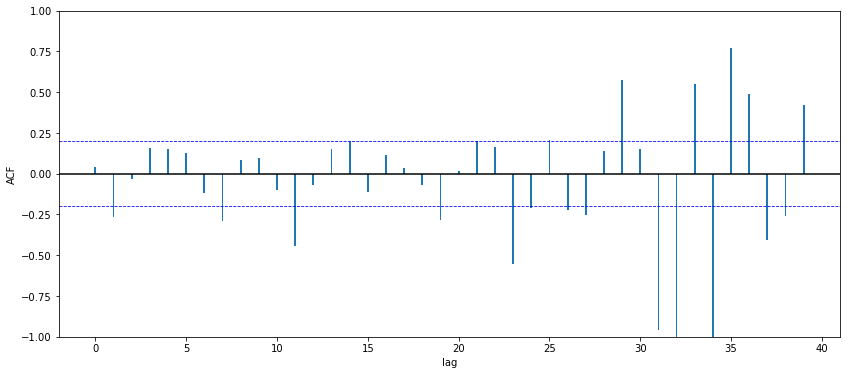

In [48]:
# Vérification du paramètre P = 1
plot_sortie_acf(pacf(np.asarray(y_12[13:])), y_len, pacf=True)

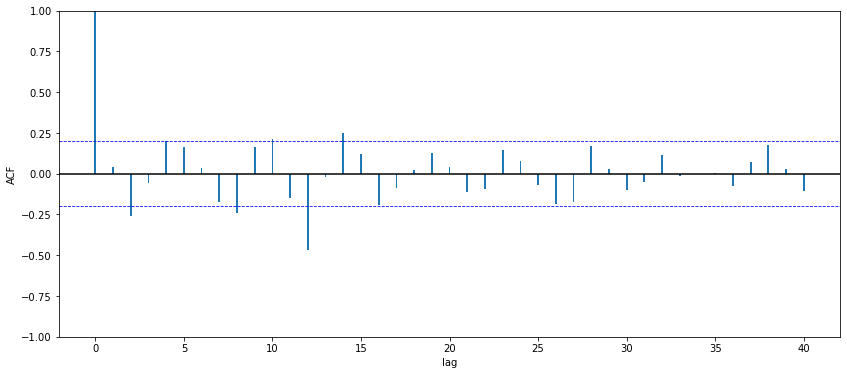

In [49]:
# Vérification du paramètre Q = 0
plot_sortie_acf(acf(np.asarray(y_12[13:])), y_len)

#### 4 - Modélisation :

In [50]:
# Modélisation :
model1 = SARIMAX(np.asarray(y["Consommation_corrigée"]), order=(5,1,0), seasonal_order=(1,0,1,12))
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))
    
shapiro(results1.resid)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   96
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 190.865
Date:                              Mon, 07 Jun 2021   AIC                           -365.730
Time:                                      16:33:30   BIC                           -345.299
Sample:                                           0   HQIC                          -357.474
                                               - 96                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9519      0.111     -8.590      0.000      -1.169      -0.735
ar.L2         -0.93

ShapiroResult(statistic=0.09517490863800049, pvalue=1.3678735005432972e-21)

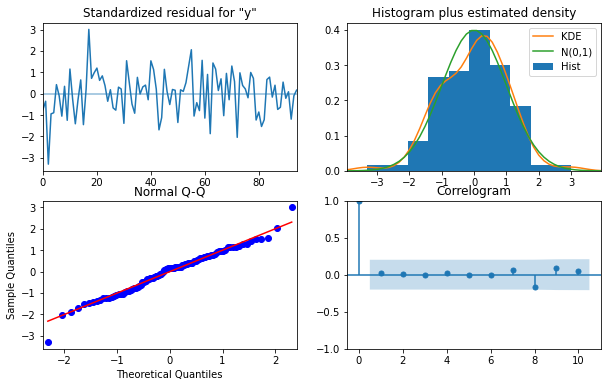

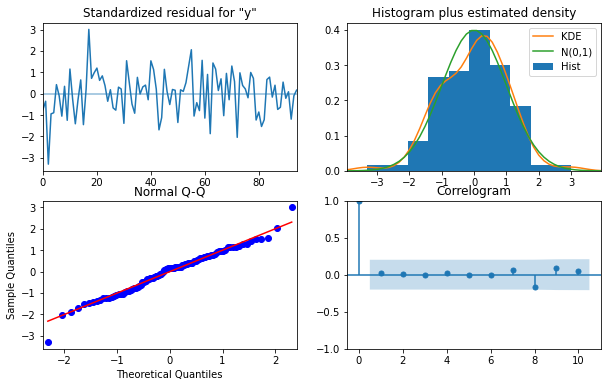

In [51]:
# Visualisation du diagnostic :
results1.plot_diagnostics(figsize = (10,6))

#### 5 - Prédiction :

In [52]:
# Récupération des données du modèle
pred_model = results1.get_forecast(12)
pred = np.exp(pred_model.predicted_mean)
pred_l = [np.exp(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [np.exp(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

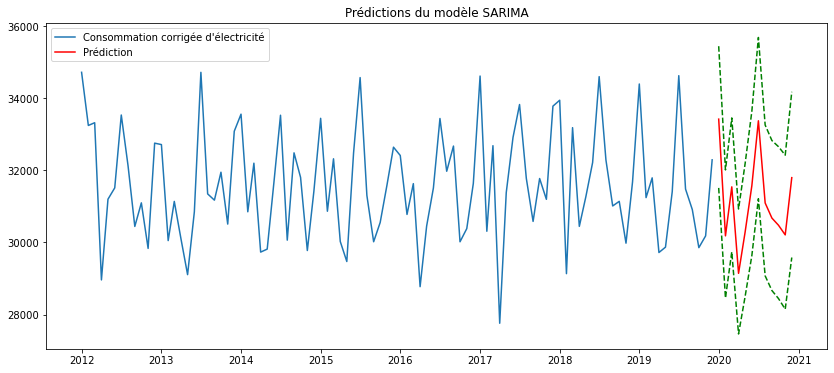

In [53]:
# Visualisation :
plt.figure(figsize=(14,6))
plt.plot(x["Consommation_corrigée"], label="Consommation corrigée d'électricité")
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label="Prédiction")
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédictions du modèle SARIMA")
plt.legend()
plt.show()

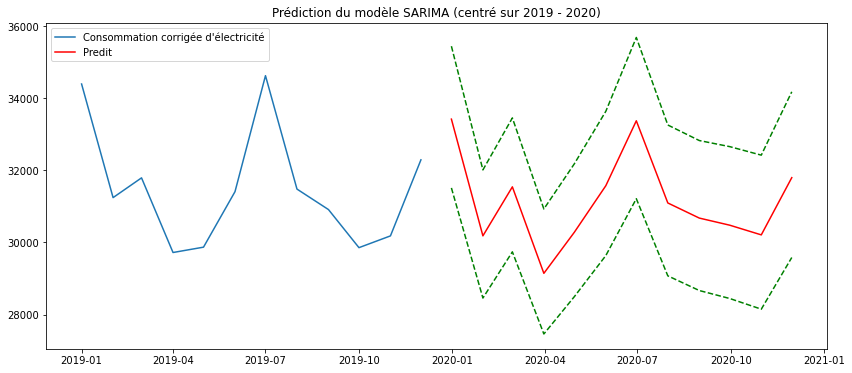

In [54]:
# Visualisation sur les dernières années :
plt.figure(figsize=(14,6))
plt.plot(x["Consommation_corrigée"]["2019":], label="Consommation corrigée d'électricité")
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédiction du modèle SARIMA (centré sur 2019 - 2020)")
plt.legend()
plt.show()

#### 6 - Analysé à posteriori :

In [55]:
# Découpage
x_tronc = x[:"2018"]
y_tronc = np.log(x_tronc)
x_a_prevoir = x["2019":]

In [56]:
# Vérification du modèle
modeltronc = SARIMAX(np.asarray(y_tronc["Consommation_corrigée"]), order=(5,1,0), seasonal_order=(1,0,1,12))
resultstronc = modeltronc.fit()
print(resultstronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(resultstronc.resid, lags=elt)[1].mean()))
    
shapiro(resultstronc.resid)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   84
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 162.078
Date:                              Mon, 07 Jun 2021   AIC                           -308.157
Time:                                      16:33:32   BIC                           -288.806
Sample:                                           0   HQIC                          -300.383
                                               - 84                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9028      0.133     -6.776      0.000      -1.164      -0.642
ar.L2         -0.84

ShapiroResult(statistic=0.10395008325576782, pvalue=3.175110486182349e-20)

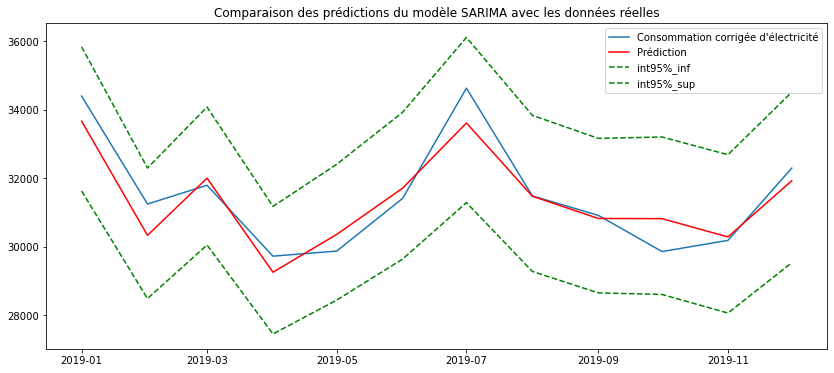

In [57]:
# Prédiction et comparaison :
pred_modeltronc = resultstronc.get_forecast(12)
pred_tronc = np.exp(pred_modeltronc.predicted_mean)
pred_l_tronc = [np.exp(elt[0]) for elt in pred_modeltronc.conf_int(alpha=0.05)]
pred_u_tronc = [np.exp(elt[1]) for elt in pred_modeltronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label="Consommation corrigée d'électricité")
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label="Prédiction")
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.title("Comparaison des prédictions du modèle SARIMA avec les données réelles")
plt.legend()
plt.show()

#### 7 - Indices de l'efficacité des prédictions :

In [58]:
# RMSE :
rmse = np.sqrt(((x_a_prevoir["Consommation_corrigée"]-pred_tronc)**2).mean())
rmse

583.046014011401

In [59]:
# MAPE :
mape=(np.abs(1-pred_tronc/x_a_prevoir["Consommation_corrigée"])).mean()*100
mape

1.485808611956637